In [20]:
import pandas as pd
from pycaret.classification import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Cargar los datos
df = pd.read_csv("caso5_marketing_conversion.csv")




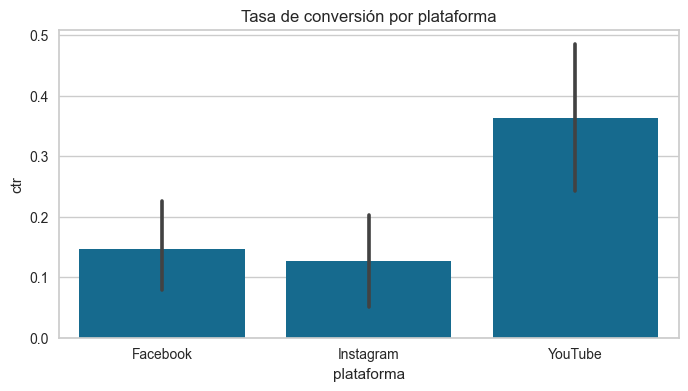

In [21]:
# 2. Análisis exploratorio: CTR por plataforma
df['ctr'] = df['conversion']
plt.figure(figsize=(8,4))
sns.barplot(data=df, x='plataforma', y='ctr')
plt.title("Tasa de conversión por plataforma")
plt.show()



In [22]:
# 3. Feature engineering: engagement combinado
df['engagement'] = np.sqrt(df['likes'] * 0.7 + df['comentarios'] * 1.5)

# Binning inteligente: duración en rangos
df['duracion_categoria'] = pd.cut(df['duracion_video_seg'],
                                  bins=[0, 30, 60, 120],
                                  labels=['Corto', 'Medio', 'Largo'])

# Interacción de plataforma con segmento
df['canal_segmento'] = df['plataforma'] + "_" + df['segmento']



In [23]:
# 4. PyCaret: setup con técnicas avanzadas
clf = setup(data=df,
            target='conversion',
            session_id=2025,
            categorical_features=['plataforma', 'segmento', 'duracion_categoria', 'canal_segmento'],
            ignore_features=['ctr', 'duracion_video_seg'],  # lo reemplazamos por la versión binned
            normalize=True,
            feature_selection=True,
            remove_multicollinearity=True,
            transformation=True,
            transformation_method='yeo-johnson',
)



,Description,Value
0,Session id,2025
1,Target,conversion
2,Target type,Binary
3,Original data shape,"(220, 10)"
4,Transformed data shape,"(220, 2)"
5,Transformed train set shape,"(154, 2)"
6,Transformed test set shape,"(66, 2)"
7,Ignore features,2
8,Numeric features,3
9,Categorical features,4


In [24]:
# 5. Comparar modelos por F1 (conversion es evento raro)
best = compare_models(sort='F1')



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7533,0.6334,0.3500,0.3250,0.3333,0.1882,0.1877,0.1050
rf,Random Forest Classifier,0.7533,0.7136,0.3500,0.3250,0.3333,0.1882,0.1877,0.2770
ada,Ada Boost Classifier,0.7908,0.6650,0.2750,0.4167,0.3167,0.2175,0.2287,0.1810
gbc,Gradient Boosting Classifier,0.7533,0.6937,0.3167,0.2917,0.3000,0.1604,0.1576,0.1760
et,Extra Trees Classifier,0.7338,0.6340,0.2833,0.2917,0.2857,0.1283,0.1257,0.1770
knn,K Neighbors Classifier,0.7525,0.6390,0.1500,0.2750,0.1852,0.0698,0.0760,0.1140
svm,SVM - Linear Kernel,0.7225,0.5496,0.1583,0.0952,0.1171,0.0206,0.0236,0.1140
lightgbm,Light Gradient Boosting Machine,0.7663,0.6420,0.0667,0.1500,0.0900,0.0238,0.0287,0.1420
lr,Logistic Regression,0.7925,0.6506,0.0000,0.0000,0.0000,0.0000,0.0000,1.3260
nb,Naive Bayes,0.7925,0.6506,0.0000,0.0000,0.0000,0.0000,0.0000,0.1280


In [25]:
ada=create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8750,0.6354,0.5000,1.0000,0.6667,0.6000,0.6547
1,0.7500,0.7812,0.2500,0.5000,0.3333,0.2000,0.2182
2,0.8750,0.8974,0.6667,0.6667,0.6667,0.5897,0.5897
3,0.8750,0.6410,0.3333,1.0000,0.5000,0.4483,0.5375
4,0.8667,0.8889,0.6667,0.6667,0.6667,0.5833,0.5833
5,0.7333,0.5139,0.3333,0.3333,0.3333,0.1667,0.1667
6,0.8000,0.8750,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7333,0.3056,0.0000,0.0000,0.0000,-0.1111,-0.1336
8,0.7333,0.5278,0.0000,0.0000,0.0000,-0.1111,-0.1336


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7500,0.6771,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7500,0.8125,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8750,0.7692,0.3333,1.0000,0.5000,0.4483,0.5375
3,0.8750,0.8205,0.3333,1.0000,0.5000,0.4483,0.5375
4,0.8667,0.8889,0.3333,1.0000,0.5000,0.4444,0.5345
5,0.8000,0.6944,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.8000,0.6806,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.8000,0.3750,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8000,0.6250,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


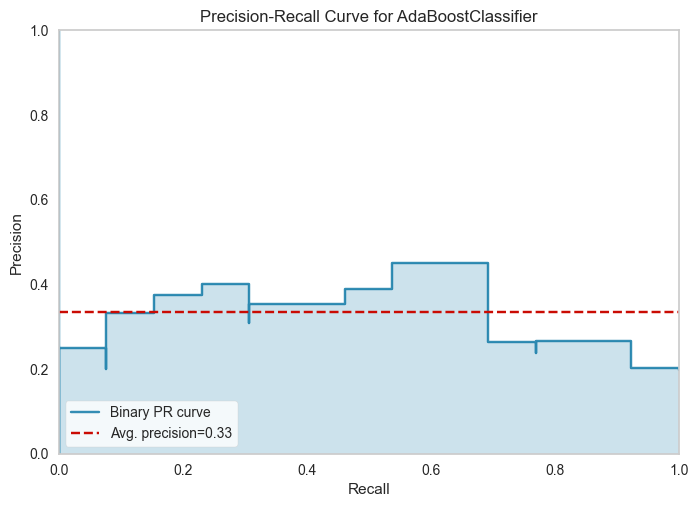

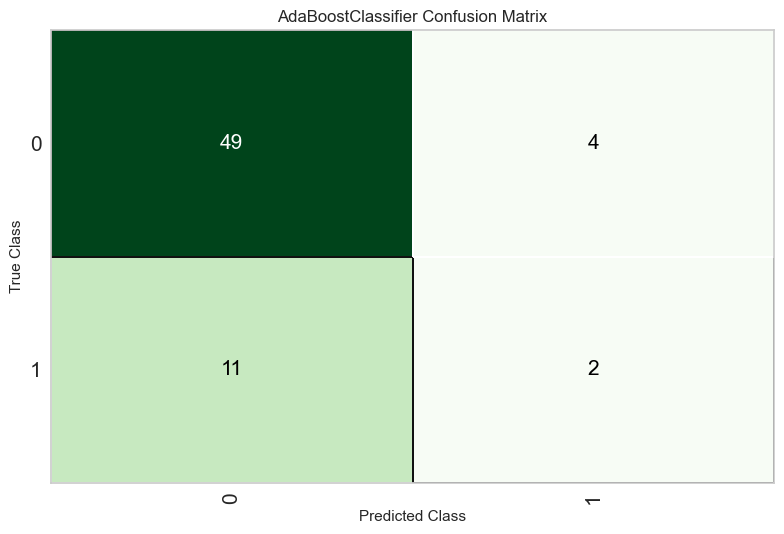

In [ ]:
# 6. Ajuste fino y visualización
# Afinar con Recall (para no perder fugas)
final = tune_model(ada, optimize='Recall')
plot_model(final, plot='pr')  # Precision-Recall
plot_model(final, plot='confusion_matrix')



In [27]:

# 7. Interpretabilidad con SHAP
interpret_model(final)



TypeError: This function only supports tree based models for binary classification: lightgbm, dt, et, rf.

In [ ]:
# Simulación de un nuevo cliente con perfil potencialmente riesgoso
nuevo_cliente = pd.DataFrame({
    'edad': [58],
    'segmento': ['Premium'],
    'saldo_total': [18500],
    'numero_productos': [2],
    'visitas_app_mes': [1],
    'usa_web': [1],
    'usa_tarjeta_credito': [1],
    'reclamos_6m': [0],
    'satisfaccion_encuesta': [3],
    'tasa_credito_personal': [18.0],
    'rango_ingresos': ['Muy Alto'],
    'region': ['Costa']
})

# Predicción con el modelo final ajustado
resultado = predict_model(final, data=nuevo_cliente)

# Mostrar si se predice que se irá (1) o no (0) y su probabilidad
print("¿Se predice que cerrará su cuenta?:", resultado[['prediction_label', 'prediction_score']])



Conversión esperada:    prediction_label  prediction_score
0                 0            0.5304


In [ ]:
# 9. Exportar modelo para uso por el equipo creativo
save_model(final, 'modelo_marketing_conversion_predictor')